_Disclaimer: This notebook is only for experimental explorative purposes only and its output is not used in the paper._

In [1]:
# main python2 compatibility import
from __future__ import print_function, division

# sage compatibility
%matplotlib inline

import numpy as np
import scipy.optimize as so
import matplotlib.pylab as plb

import matplotlib.pylab as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.7)

In [2]:
from integrators.common import getsteps, relerr as relerr2

osc = lambda p,x,z,t,a: -x-a*p*z

# Contact integrators

The integrator for the quadratic oscillator case is implicit. You can see the implementations below.

In [3]:
def quadratic(init, tspan, a, h):
    steps = getsteps(tspan, h)
    hsq = np.math.pow(h,2)
    
    sol = np.empty([steps, 3], dtype=np.float64)
    sol[0] = np.array(init)
    for i in range(steps-1):
        p, x, z = sol[i]
        def F(xz):
            xnew, znew = xz
            return np.array([
                    (h-hsq*a*znew)*p + (1.0 - hsq/2.0)*x - xnew,
                    z + h/2.0*((xnew - x) / h)**2 - h/4.0 * (x**2 + xnew**2) - .5*h*a*(z**2) - znew
                    ])
        tmp = np.array([x,z])
        xnew, znew = so.fsolve(F, tmp)
        pnew = (1 - h*a*znew)*p - h/2.0*(xnew + x)
        sol[i+1] = np.array([pnew, xnew, znew])
    return sol

def symquadratic(init, tspan, a, h):
    steps = getsteps(tspan, h)
    hsq = np.math.pow(h,2)
    
    sol = np.empty([steps, 3], dtype=np.float64)
    sol[0] = np.array(init)
    for i in range(steps-1):
        p, x, z = sol[i]
        def F(pxz):
            pnew, xnew, znew = pxz
            return np.array([
                    (1 - h*a*z/2.0)*p - h/2.0*(xnew + x) - (1 + h*a*znew/2.0)*pnew,
                    h*(1 - h*a*z/2.0)*p + (1.0 - hsq/2.0)*x - xnew,
                    z - znew + h/2.0*((xnew - x) / h)**2 - h/4.0*(x**2 + xnew**2) - h/4.0*a*(z**2 + znew**2)
                    ])
        tmp = np.array([p,x,z])
        pnew, xnew, znew = so.fsolve(F, tmp) 
        sol[i+1] = np.array([pnew, xnew, znew])
    return sol      

# Symplectic integrators (hand adapted)

In this case symplectic integrators cannot be applied as-is. One should introduce a dummy variable to make the system eve-dimensional again. Below we add some hand crafted implementations for the comparison.

_Note that the comparison will not be very meaningful in this case, so we decided to omit it from the paper._

In [4]:
def rk4(init, tspan, a, h, acc):
    t = np.arange(tspan[0], tspan[1], h)
    lag = lambda p,q,z: p**2/2.0 - q**2/2.0 - a*z**2/2.0
    def derivs(x,t):
        dp = acc(x[0],x[1],x[2],0,a)
        dq = x[0]
        dz = lag(x[0],x[1],x[2])
        return (dp, dq, dz)
    return plb.rk4(derivs, init, t)

#explicit midpoint
def midpoint(init, tspan, a, h, acc):
    steps = getsteps(tspan, h)
    hsq = np.math.pow(h,2)
    lacc = lambda p,q,z: acc(p,q,z,0,a)
    lag = lambda p,q,z: p**2/2.0 - q**2/2.0 - a*z**2/2.0
    
    sol = np.empty([steps, 3], dtype=np.float64)
    sol[0] = np.array(init)
    for i in range(steps-1):
        p,x,z = sol[i]
        half = h/2.0
        pmid = p + half*lacc(p, x, z)
        xmid = x + half*p
        zmid = z + half*lag(p, x, z)
        
        pnew = p + h*lacc(pmid, xmid, zmid)
        xnew = x + h*pmid
        znew = z + h*lag(pmid, xmid, zmid)
        sol[i+1] = np.array((pnew, xnew, znew))
    return sol

def leapfrog(init, tspan, a, h, acc):
    steps = getsteps(tspan, h)
    hsq = np.math.pow(h,2)
    lacc = lambda p,q,z: acc(p,q,z,0,a)
    
    sol = np.empty([steps, 3], dtype=np.float64)
    sol[0] = np.array(init)
    for i in range(steps-1):
        p,x,z = sol[i]
        xnew = x + h*p + hsq/2.0*lacc(p, x, z)
        znew = so.fsolve(
            lambda znew: z - znew + h*(.5*((xnew-x)/h)**2 - .25*(x**2 + xnew**2) - .25*a*(z**2 + znew**2))
            , z
        )
        pnew = p + h*(lacc(p, x, z) + lacc(p, xnew, znew))/2.0
        sol[i+1] = np.array((pnew, xnew, znew))
    
    return sol

In [5]:
def cmp_plot(init, tspan, a, h, delta, delta2=1, acc=osc, save=False):
    
    #r = leapfrog(init, tspan, a, h/delta, acc)
    r = rk4(init, tspan, a, h/delta, acc)

    s1 = quadratic(init, tspan, a, h/delta2)
    s2 = rk4(init, tspan, a, h, acc)
    s3 = symquadratic(init, tspan, a, h/delta2)
    s4 = midpoint(init, tspan, a, h, acc)
    s5 = leapfrog(init, tspan, a, h, acc)
    
    #relerr = lambda ref, sol: np.abs(sol-ref)
    relerr = lambda ref, sol: 0.5*relerr2(ref,sol)
    ts = np.arange(tspan[0], tspan[1], h)[:len(s1[:,1])]
    
    # This may be needed when the time step or the delta are not even
    rtrim = r[::delta,1]
    rtrim = rtrim[:len(s1[:,1])]
    r2trim = r[::delta,2]
    r2trim = r2trim[:len(s1[:,1])]

    s1trim = s1[::delta2,1]
    s1trim = s1trim[:len(s1[:,1])]
    s12trim = s1[::delta2,2]
    s12trim = s12trim[:len(s1[:,1])]
        
    plt.figure(figsize=(20,15))    
    
    plt.subplot(311)
    plt.title("Solution for $h={}$, $\\alpha={}$, $(p_0,q_0,z_0)={}$".
              format(h, a, tuple(init))
             )
    plt.plot(np.arange(tspan[0], tspan[1], h/delta2)[:len(s1[:,1])], s1[:,1], label="Contact (1st)", linestyle="--")
    plt.plot(np.arange(tspan[0], tspan[1], h/delta2)[:len(s3[:,1])], s3[:,1], label="Contact (2nd)", linestyle="-.")
    plt.plot(ts, s2[:,1], label="Runge-Kutta (4th)", linestyle="-")
    plt.plot(ts, s4[:,1], label="Explicit midpoint (2nd)", linestyle=":")
    plt.plot(ts, s5[:,1], label="Leapfrog", linestyle=":")
    plt.plot(np.arange(tspan[0], tspan[1], h/delta)[:len(r[:,1])], r[:,1], label="Reference", linestyle="-")
    plt.legend()
    
    plt.subplot(312)
    plt.title("z-component")
    plt.plot(np.arange(tspan[0], tspan[1], h/delta2)[:len(s1[:,2])], s1[:,2], label="Contact (1st)", linestyle="--")
    plt.plot(np.arange(tspan[0], tspan[1], h/delta2)[:len(s3[:,2])], s3[:,2], label="Contact (2nd)", linestyle="-.")
    plt.plot(ts, s2[:,2], label="Runge-Kutta (4th)", linestyle="-")
    plt.plot(ts, s4[:,2], label="Explicit midpoint (2nd)", linestyle=":")
    plt.plot(ts, s5[:,2], label="Leapfrog", linestyle=":")
    plt.plot(np.arange(tspan[0], tspan[1], h/delta)[:len(r[:,2])], r[:,2], label="Reference", linestyle="-")
    plt.legend()
    
    plt.subplot(313)
    plt.title("Relative Error")
    plt.plot(ts, relerr(rtrim,s1trim) + relerr(r2trim,s12trim), label="Contact (1st)", linestyle="--")
    plt.plot(ts, relerr(rtrim,s3[:,1]) + relerr(r2trim,s3[:,2]), label="Contact (2nd)", linestyle="-.")
    plt.plot(ts, relerr(rtrim,s2[:,1]) + relerr(r2trim,s2[:,2]), label="Runge-Kutta (4th)", linestyle="-")
    plt.plot(ts, relerr(rtrim,s4[:,1]) + relerr(r2trim,s4[:,2]), label="Explicit midpoint (2nd)", linestyle=":")
    plt.plot(ts, relerr(rtrim,s5[:,1]) + relerr(r2trim,s5[:,2]), label="Leapfrog", linestyle=":")
    plt.legend()
    
    if save:
        name = "quadratic{}.pdf".format(a)
        plt.savefig(name, format="pdf", transparent=True)

    plt.show()

/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: scipy.integrate.ode
  if __name__ == '__main__':


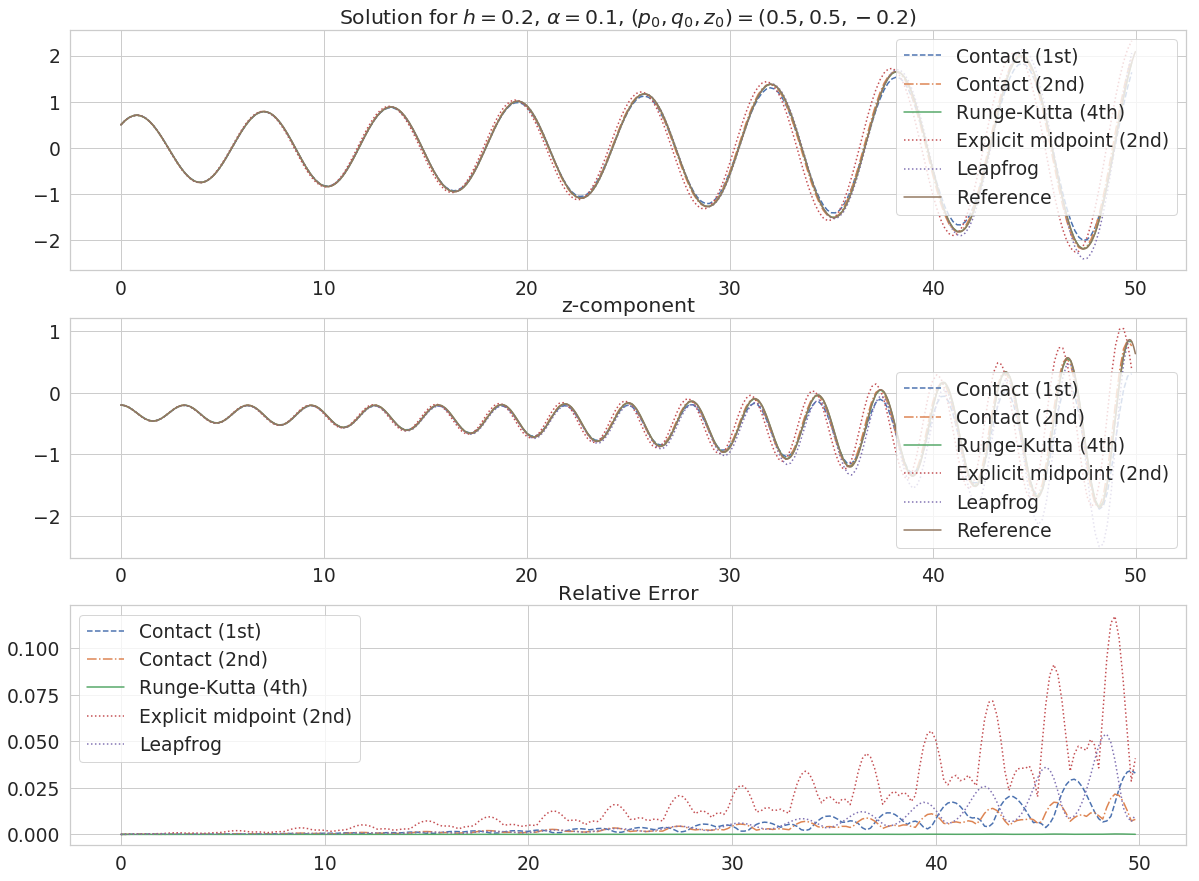

In [6]:
init = (.5, .5, -.2)
#init = .5*np.random.rand(3)
tspan = (0.0, 50.0)
a = .1
h = 0.2
delta = 10

cmp_plot(init, tspan, a, h, delta, delta2=1)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: scipy.integrate.ode
  if __name__ == '__main__':
/home/mseri/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


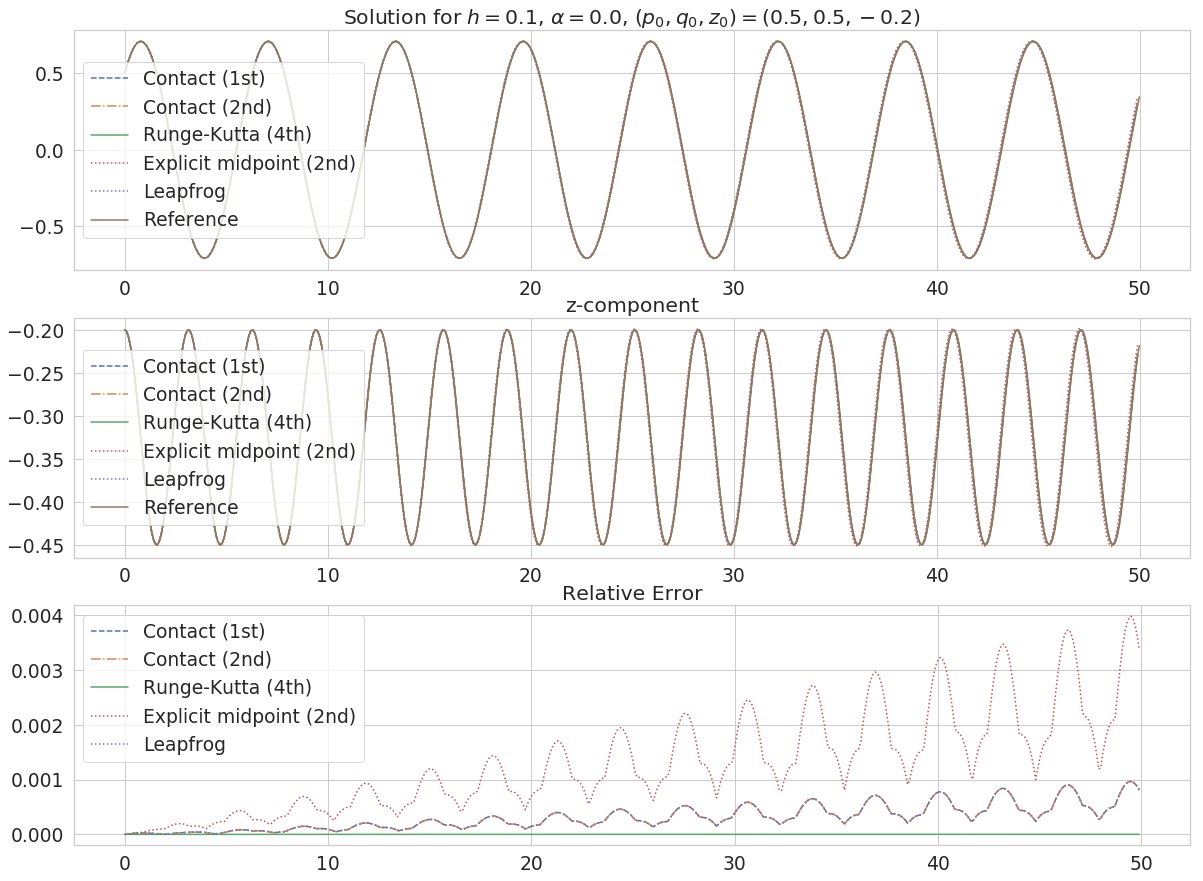

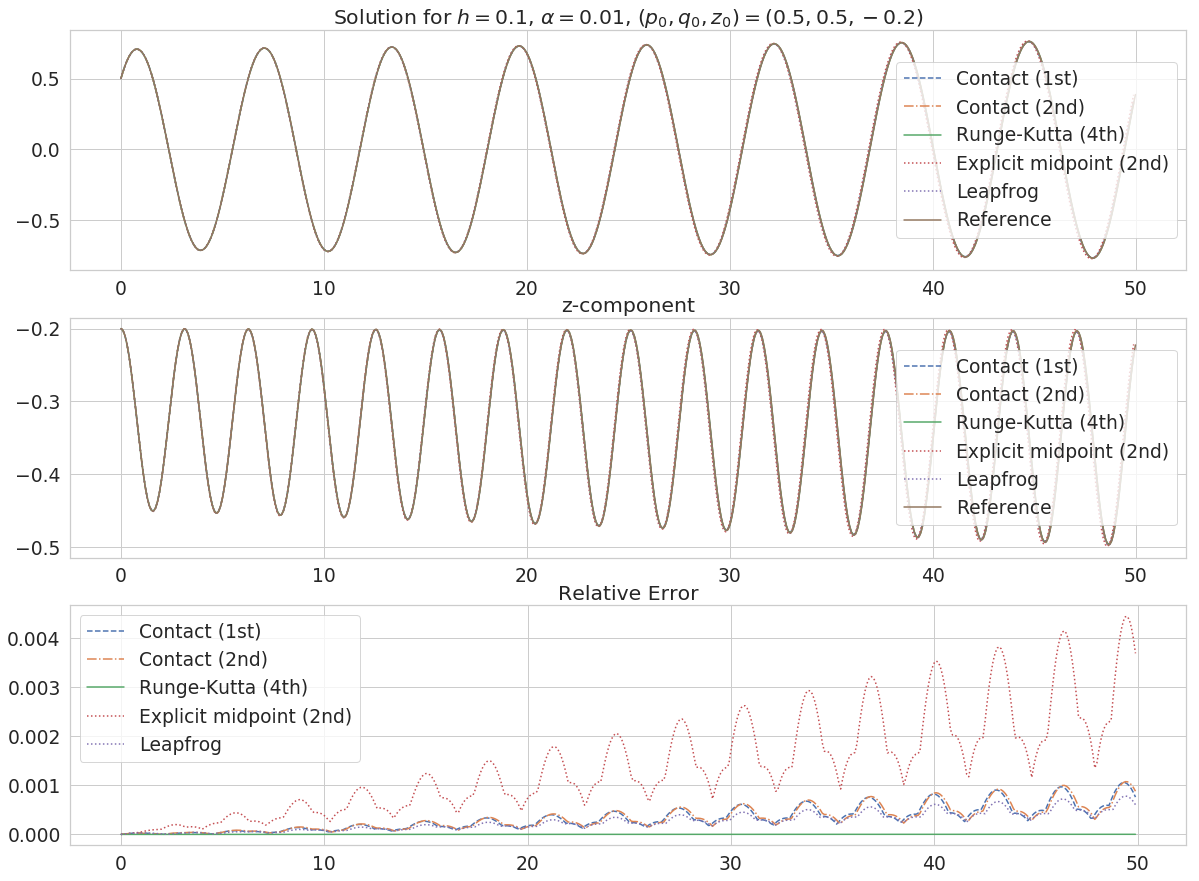

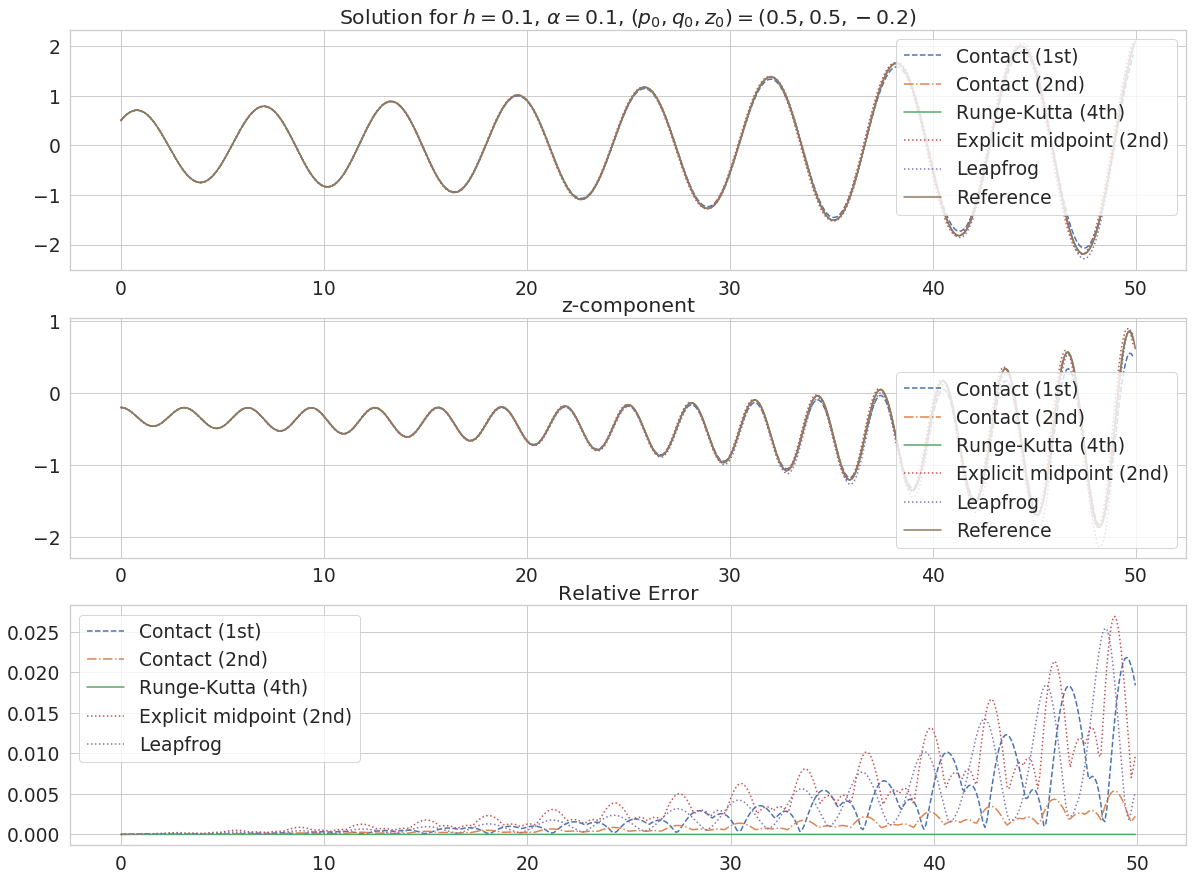

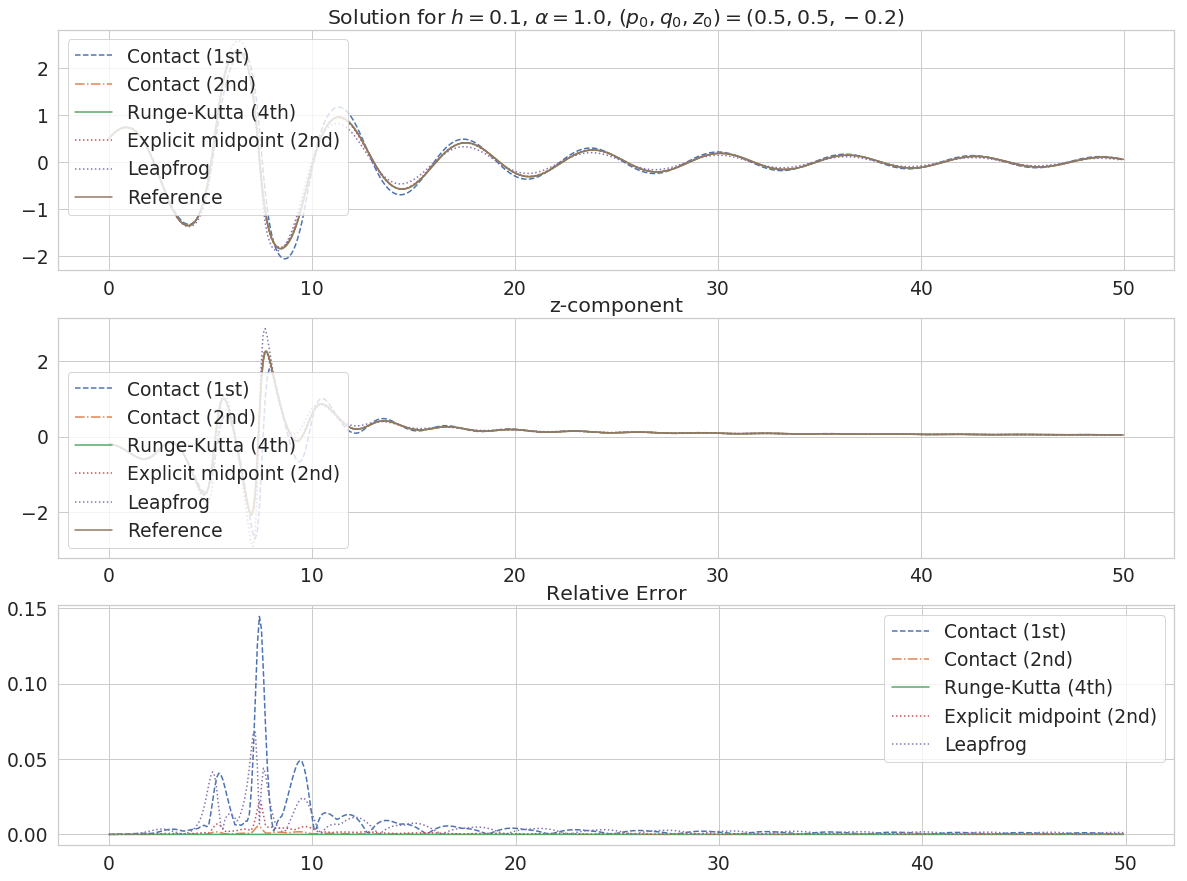

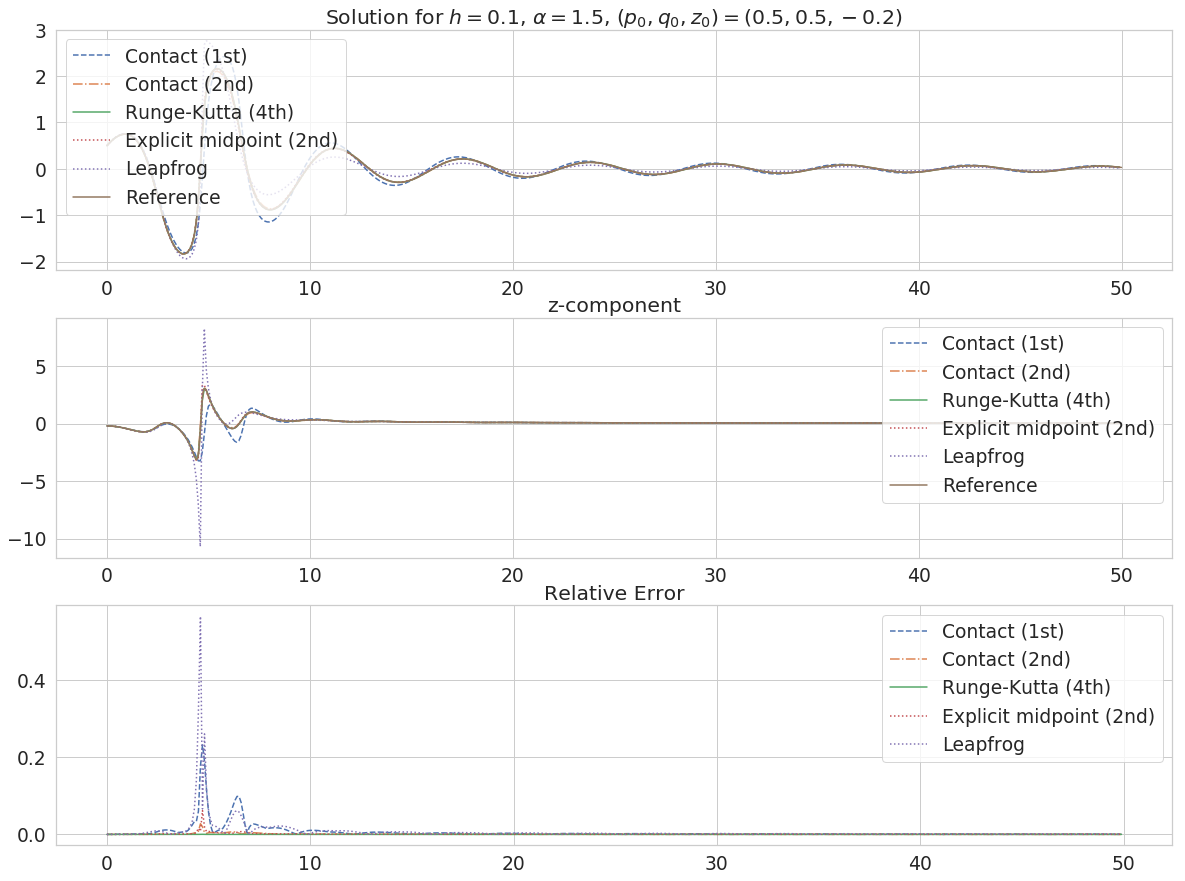

In [7]:
#init = 0.5*np.random.rand(3)
init = (.5, .5, -.2)
tspan = (0.0, 50.0)
delta = 10
    
for a in [0.0, 0.01, 0.1, 1.0, 1.5]:
    for h in [.1]:
        cmp_plot(init, tspan, a, h, delta)